# Sea Surface Height — NEMO GYRE

Analyse SSH (`sossheig`) from the GYRE simulation.
- Temporal variance (spatial map)
- Domain-mean SSH time series

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import nc_time_axis  # noqa: F401 — registers cftime support in matplotlib

from gyre import load_output, load_mesh, interior_mask, cell_area, gyre_map

plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})

OUTPUT_DIR = Path("../output")

## Load simulation output

Load the recombined grid_T file (SSH, SST, SSS) and the mesh_mask
(grid geometry and land/sea mask). Cell widths `e1t`/`e2t` from the
mesh_mask are used for area-weighted spatial averaging.

In [2]:
ds = load_output("*_grid_T.nc", OUTPUT_DIR)
mesh = load_mesh(OUTPUT_DIR)

interior = interior_mask(mesh.tmask.isel(nav_lev=0))
area = cell_area(mesh)

ssh = ds["sossheig"]
ssh

<xarray.DataArray 'sossheig' (time_counter: 1800, y: 102, x: 152)> Size: 112MB
dask.array<open_dataset-sossheig, shape=(1800, 102, 152), dtype=float32, chunksize=(1, 102, 152), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) object 14kB 0001-01-06 00:00:00 ... 0050-12-...
  * y             (y) int64 816B 0 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100 101
  * x             (x) int64 1kB 0 1 2 3 4 5 6 7 ... 145 146 147 148 149 150 151
    nav_lon       (y, x) float32 62kB dask.array<chunksize=(102, 152), meta=np.ndarray>
    nav_lat       (y, x) float32 62kB dask.array<chunksize=(102, 152), meta=np.ndarray>
Attributes:
    units:               m
    standard_name:       Sea Surface Height
    long_name:           Sea Surface Height
    online_operation:    ave(x)
    interval_operation:  2880.0
    interval_write:      864000.0

## SSH temporal variance

Variance over time at each grid point.

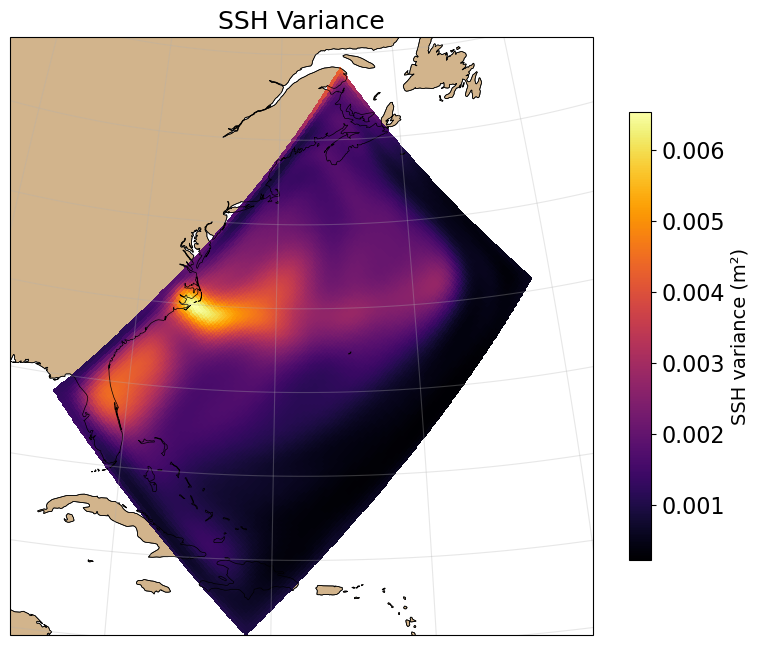

In [3]:
ssh_var = ssh.var("time_counter").where(interior)

fig, ax = gyre_map(ds=ds)

pcm = ax.pcolormesh(
    ds.nav_lon.values, ds.nav_lat.values, ssh_var.values,
    shading="auto", cmap="inferno", transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="SSH variance (m²)", shrink=0.7)
ax.set_title("SSH Variance")
fig.tight_layout()
fig.savefig("../figures/ssh_variance.png", dpi=150, bbox_inches="tight")

## Domain-mean SSH time series

Area-weighted SSH averaged over interior ocean points.

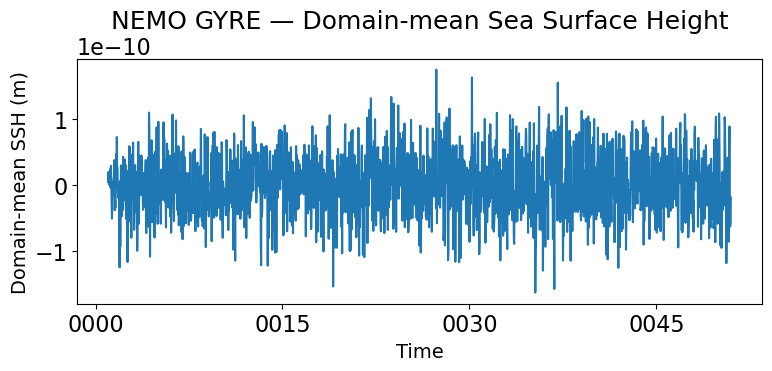

In [4]:
weights = area * interior
ssh_mean = ssh.weighted(weights).mean(["y", "x"])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ssh_mean.time_counter, ssh_mean)
ax.set_xlabel("Time")
ax.set_ylabel("Domain-mean SSH (m)")
ax.set_title("NEMO GYRE — Domain-mean Sea Surface Height")
fig.tight_layout()